# Experiments for checking the effect of sampling technique

this is the experiment only for different version of our algorithm. We choose several sampling technique and compare them.

1. random uniform
2. estimate P(x) and sampling from it
3. our first term (sample far away from previous instances)
4. our second term (sample near the decision boundary)

In [1]:
# for reproducibility
random_seed=42

## Preparing data and black (In Orange framework, it is simple and good)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

def f(x,y):
        return np.sin(10 * x) + np.cos(4 * y)  - np.cos(3*x*y) 

def predict(X):
    def f_binary(x):
        return int(1) if np.sin(10 * x[0]) + np.cos(4 * x[1])  - np.cos(3*x[0]*x[1]) >= 0 else int(0)
  
    X = np.array(X)
    if X.ndim == 1:
        y = f_binary(X)
    elif X.ndim==2:
        y = np.array(list(map(f_binary, X )) )
    else:
        print("error, blackbox function")
    return y



prepare the dataset and the data encoder

In [3]:
%load_ext autoreload
%autoreload 2
from prepare_dataset import prepare_2d_sinusoidal_dataset
from utils import encoder_from_datatable



data_table = prepare_2d_sinusoidal_dataset(number=100)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data_table.X,data_table.Y,test_size=0.5,random_state=random_seed)

from Orange.data import Table
data_table = Table.from_numpy(X=X_train,Y=y_train,domain=data_table.domain)

test_data_table = Table.from_numpy(X=X_test,Y=y_test,domain=data_table.domain)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# in this case the encoder is only a void passing, nothing is changed since 2-d dataset is simple two continuous variable

categorical_features_idx = [i for i,a in enumerate(data_table.domain.attributes) if a.is_discrete]

scikit_encoder = make_column_transformer(
                            ( OneHotEncoder(categories='auto'),categorical_features_idx),
                            remainder = 'passthrough'
                            )
scikit_encoder.fit(data_table.X)

black_box = lambda x:  predict(scikit_encoder.transform(x))

print("now start sanity-check")
print("the first row of the dataset is (orginal form):\n", data_table[0] )
print("the first row of the dataset is (only X data):\n", data_table.X[0])
print("the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):\n ",scikit_encoder.transform([data_table.X[0]] ))
print("the predition of blackbox on the first row:\n", black_box( [data_table.X[0]]  )   )



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
now start sanity-check
the first row of the dataset is (orginal form):
 [0.725, 1.400 | yes]
the first row of the dataset is (only X data):
 [0.725 1.4  ]
the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):
  [[0.7250000000000001 1.4000000000000001]]
the predition of blackbox on the first row:
 [1]


## Ours

In [10]:
%load_ext autoreload
%autoreload 2
from approach import explain_tabular
# iter_max = 1000
explanations,ADS = explain_tabular(data_table, black_box, target_class="yes", random_seed=42,beta=0)
# explanations,ADS = explain_tabular(data_table, black_box, target_class="yes", random_seed=42,beta=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


new best obj: 0.8099999999999999 number of rules 1
new best obj: 0.84 number of rules 2
new best obj: 0.86 number of rules 2
new best obj: 0.88 number of rules 2
new best obj: 0.89 number of rules 3
the result accuracy 0.92
the number of rules 3
the number of new instances generated 0


IF 0.04253427838878401 <= x-axis <= 0.9750000000000001 AND 1.2920000000000003 <= y-axis <= 1.85 THEN hit=yes 
IF 0.0 <= x-axis <= 0.2829826978297634 AND 0.05 <= y-axis <= 0.34506748057087205 THEN hit=yes 
IF 0.6775959817440392 <= x-axis <= 0.9262500000000001 THEN hit=yes 
24
27.0
Blackbox and our, acc 0.9
Blackbox and our, f1 score 0.9019607843137256
Blackbox and our,recall 0.8518518518518519
Blackbox and our,precision 0.9583333333333334


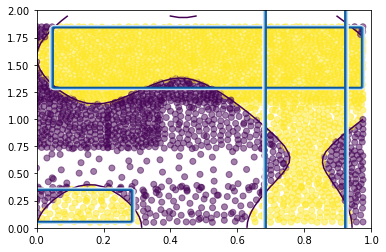

number of rules: 3
IF 0.04253427838878401 <= x-axis <= 0.9750000000000001 AND 1.2920000000000003 <= y-axis <= 1.85 THEN hit=yes 
IF 0.0 <= x-axis <= 0.2829826978297634 AND 0.05 <= y-axis <= 0.34506748057087205 THEN hit=yes 
IF 0.6775959817440392 <= x-axis <= 0.9262500000000001 THEN hit=yes 


In [8]:
%matplotlib inline

from utils import  rule_to_string,ruleset_predict

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)


delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)

# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

from utils import  rule_to_string
print('number of rules:',len(explanations))
for e in explanations:
    print(rule_to_string(e,data_table.domain,1))